<h1><center> Model to predict SIT error at a local point </center></h1>

Goal: predict the error at a specific point.

In [1]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import yaml
import pickle as pkl
import subprocess
from tensorflow.keras.regularizers import L1L2
import netCDF4 as nc4
import random
import itertools

from src.data_preparation import mdl_dataset
from src.data_preparation import load_data

from src.modelling import mdl_input_dico  # input variables class
from src.modelling import mdl_params  # parameters class
from src.modelling import mdl_history

from src.modelling import model_cnn
from src.modelling import model_lstm
# from src.modelling import super_model_dl

from src.visualization import visualize_pca
from src.visualization import mdl_introspect
from src.visualization import mdl_ypred_PCA

from src.utils import reload_config
from src.utils import tardisml_utils
from src.utils import save_name

/LUMI_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-03-02 18:28:08.168138: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/LUMI_CONTAINER/miniconda/envs/env1/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow ve

In [2]:
np.__version__

'1.19.2'

In [3]:
import tensorflow

In [4]:
import tensorboard

In [5]:
tensorboard.__version__


'2.10.0'

In [6]:
tensorflow.__version__

'2.4.1'

In [7]:
import sys
sys.version

'3.9.12 (main, Jun  1 2022, 11:38:51) \n[GCC 7.5.0]'

# Config

In [8]:
# file_config = '../config/data_proc_full.yaml'

In [9]:
# file_config = '../config/config_to_jobs/config_CNN_no_bias_0wk.yaml'
file_config = '../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml'

In [10]:
rootdir = tardisml_utils.get_rootdir()
# file_config = '../config/data_proc_full.yaml'
conf = reload_config.Config(file_config, rootdir=rootdir, verbose=1)

Config file found: ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
PCA results in: /scratch/project_465000269/edelleo1/Leo/results/pca_i100-550_j300-629
Config file updated 'pca_dir': ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
Results in: /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813
Folder created

Subfolder created: /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/ml/
Subfolder created: /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/figures/
Config file updated 'results_dir': ../config/config_to_jobs/config_LSTM_no_bias_0wk.yaml
Config folders updated.
Config copied to: /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813
Config file found: /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Default config file is now the copied following one:
/scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml


# Cluster 

In [11]:
# import Kmean group results

n_clusters = 40  #10

# idir = '/nird/projects/nird/NS2993K/Leo/results/xgb_230118-135014/ml/'
idir = f'{rootdir}Leo/results/kmean/'
ifile = f'Kmean_n{n_clusters}_2011_2019.nc'


nc = nc4.Dataset(f'{idir}{ifile}', mode='r')
km = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['km']
corr = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))['corr']


In [12]:
from src.feature_extraction import kmean_cluster
# kmean_cluster.draw(km)

In [ ]:
# Selection a random point of a defined cluster (or average over a Kmean group)
cluster_sel = 6
idx_pt = kmean_cluster.sel_rdn_pt(km, cluster_sel=cluster_sel, return_neighbors=True)

In [14]:
# select all points in the cluster
idx_pt = kmean_cluster.sel_all_pt_1cl(km, cluster_sel=cluster_sel)

In [102]:
reload(kmean_cluster)

<module 'src.feature_extraction.kmean_cluster' from '/users/edelleo1/tardis/tardis-ml/src/feature_extraction/kmean_cluster.py'>

In [103]:
# select all points in ALL the clusters
idx_pt = kmean_cluster.sel_all_pt(km)

In [104]:
len(idx_pt)

66563

In [107]:
some_pts = list(np.array(idx_pt)[::40])

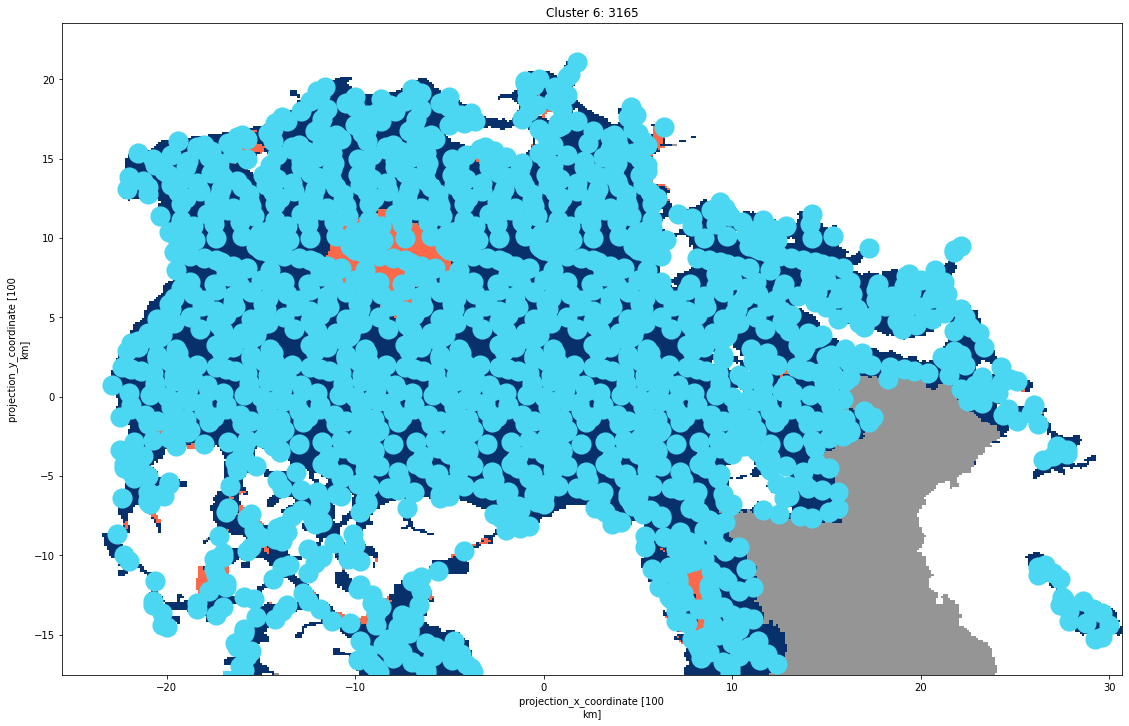

In [108]:
# visualize random point
kmean_cluster.plot_1cluster(cluster_sel, km, points=some_pts)  # idx_pt for all the points

# -----------------------------------------

# Loading Dataset

In [17]:
from src.data_preparation import load_data

In [18]:
from importlib import reload

In [19]:
reload(mdl_dataset)

<module 'src.data_preparation.mdl_dataset' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/mdl_dataset.py'>

In [20]:
from src.data_preparation import mdl_dataset_format

In [21]:
reload(mdl_dataset_format)

<module 'src.data_preparation.mdl_dataset_format' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/mdl_dataset_format.py'>

In [22]:
reload(load_data)

<module 'src.data_preparation.load_data' from '/users/edelleo1/tardis/tardis-ml/src/data_preparation/load_data.py'>

In [23]:
gfile = f'{rootdir}Leo/results/ak_230215-144514/ml/sit_gAK_2011_2019_01.nc'
gname = 'AK'

In [24]:
# setup='no_bias'
# conf.setup

ds = mdl_dataset.Dataset(conf, setup='no_bias', objective='local_train', 
                         point=idx_pt, gfile=gfile, gname=gname) # var_to_keep=var_to_keep, 

# Xeg, chrono, Xna, covar, forcings, maskok = load_data.load_dataset_g2l(conf)

# todo: provide different global dataset in load_dataset_g2l()


Initialisation dataset...
History loaded from config file: /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Loading global residual bias from: /scratch/project_465000269/edelleo1/Leo/results/ak_230215-144514/ml/sit_gAK_2011_2019_01.nc
Indexes after <<<3013>>> will be removed: not predicted by ML.
Load sia
Adding sia
Size of the training set:    1958 days
Size of the validation set:   451 days
Size of the test set:         604 days
Config file updated 'ntrain': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Config file updated 'nval': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Config file updated 'ntest': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Dataset Format for lstm
Dataset formatted from (3013, 3165, 13) to (3013, 3165, 13) for H=[0].


In [115]:
ds.redefine_point(new_point=idx_pt[::400])

Size of the training set:    1958 days
Size of the validation set:   451 days
Size of the test set:         604 days
Config file updated 'ntrain': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Config file updated 'nval': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Config file updated 'ntest': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Dataset Format for lstm
Dataset formatted from (3013, 167, 13) to (3013, 167, 13) for H=[0].


In [110]:
print(f'Number of profiles: {len(idx_pt)}')

Number of profiles: 66563


In [26]:
ds.dataset['X'].shape

(3013, 3165, 13)

In [27]:
ds.dataset.keys()

dict_keys(['X', 'y', 'chrono', 'ntrain', 'nval', 'ntest', 'chrono_train', 'chrono_val', 'chrono_test', 'Xtrain', 'Xval', 'Xtest', 'ytrain', 'yval', 'ytest'])

In [26]:
# to change point used WITHOUT RELOADING ALL DATASET:
#new_point = sel_rdn_pt(km, 6)
#ds.redefine_point(idx_pt)  # new_point)

# ---------------

try apply algo on all points of the cluster

# ---------------

## Fromatting dataset

# Run model

In [28]:
ds.config.ml_name = 'LSTM_loc'

In [29]:
from importlib import reload

In [30]:
# ---------------------------------------------------
#                 Building cnn
# ---------------------------------------------------

suffixe = ''  # useless ?
# reg = regularizers[0]
n_components = 1 # local model
    

In [31]:
from src.modelling import super_model_dl

In [92]:
reload(super_model_dl)

<module 'src.modelling.super_model_dl' from '/users/edelleo1/tardis/tardis-ml/src/modelling/super_model_dl.py'>

In [93]:
reload(model_lstm)

<module 'src.modelling.model_lstm' from '/users/edelleo1/tardis/tardis-ml/src/modelling/model_lstm.py'>

In [111]:
m3 = model_lstm.ModelLSTM(ds, ds.dataset['Xtrain'].shape[1], ds.dataset['Xtrain'].shape[2], 
                    rootdir=ds.config.rootdir, ml_dir=ds.config.ml_dir, 
                    fig_dir=ds.config.fig_dir)

In [112]:
m3.compile_models()

input change depending on model !!
Compiled !


In [113]:
m3.print_summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 32)          5888      
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 96)          61824     
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 96)          0         
_________________________________________________________________
dense_6 (Dense)              (None, None, 1)          

In [116]:
m3.fit_multiple(ds.dataset, epochs=1) 

Fitting...
490/490 [==============================] - 129s 259ms/step - loss: 0.0477 - val_loss: 0.0560
pc0 Training finished !


In [121]:
ds.redefine_point(new_point=idx_pt[::20])

Size of the training set:    1958 days
Size of the validation set:   451 days
Size of the test set:         604 days
Config file updated 'ntrain': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Config file updated 'nval': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Config file updated 'ntest': /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/config_LSTM_no_bias_0wk.yaml
Dataset Format for lstm
Dataset formatted from (3013, 3329, 13) to (3013, 3329, 13) for H=[0].


In [124]:
m3.predict_multiple(ds.dataset, point=idx_pt[::20])
# m4.save_prediction()
#m4.save_model()

95/95 [==============================] - 64s 672ms/step
Prediction finished !! - for lstm_at only


In [125]:
m3.save_prediction(ds=ds)

Save prediction as .nc
Prediction (bias of SIT, .nc) saved as: /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/ml/biasSIT_local_LSTM_loc.nc


In [98]:
m3.save_model_weights()

Saving models weights...
Saved as: /scratch/project_465000269/edelleo1/Leo/results/lstm_230302-182813/ml/model_weights_LSTM_loc_1N_PC0


# ------------------------

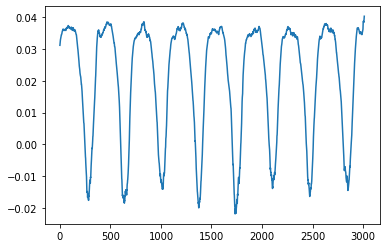

In [84]:
plt.plot(m3.ypred[:,1000]);
# plt.plot(m3.ytrue[:,0]);

In [101]:
m3.ypred.shape

(3013, 3165, 1)

In [150]:
len(m3.point)

3165

In [112]:
# put prediction back on 2D maps
# (time, lat, lon)
ntimes = ds.outputs[0].shape[0]
nlat = ds.outputs[0].shape[1]
nlon = ds.outputs[0].shape[2]
bias_pred = np.zeros((ntimes, nlat, nlon))


In [120]:
bias_pred.shape

(3013, 329, 450)

In [213]:
m3.point

[(10, 271),
 (11, 271),
 (12, 271),
 (12, 272),
 (13, 271),
 (13, 272),
 (14, 164),
 (14, 270),
 (14, 271),
 (14, 272),
 (14, 273),
 (15, 270),
 (15, 271),
 (15, 272),
 (15, 273),
 (16, 263),
 (16, 270),
 (16, 271),
 (16, 272),
 (16, 273),
 (17, 262),
 (17, 270),
 (17, 271),
 (17, 272),
 (17, 273),
 (18, 270),
 (18, 271),
 (18, 272),
 (18, 273),
 (19, 261),
 (19, 270),
 (19, 271),
 (19, 272),
 (19, 273),
 (20, 269),
 (20, 270),
 (20, 271),
 (20, 272),
 (21, 269),
 (21, 270),
 (21, 271),
 (22, 262),
 (22, 263),
 (22, 266),
 (22, 269),
 (22, 270),
 (22, 271),
 (22, 272),
 (23, 131),
 (23, 132),
 (23, 133),
 (23, 262),
 (23, 265),
 (23, 266),
 (23, 268),
 (23, 269),
 (23, 270),
 (23, 271),
 (23, 272),
 (24, 130),
 (24, 131),
 (24, 132),
 (24, 265),
 (24, 268),
 (24, 269),
 (24, 270),
 (24, 271),
 (24, 272),
 (25, 129),
 (25, 130),
 (25, 131),
 (25, 132),
 (25, 268),
 (25, 269),
 (25, 270),
 (25, 271),
 (25, 272),
 (25, 273),
 (26, 123),
 (26, 127),
 (26, 128),
 (26, 129),
 (26, 130),
 (26

In [215]:
# put back the result for each point

for idx, pt in enumerate(m3.point[::-1]):
#     print(pt)
    bias_pred[:, pt[0], pt[1]] = m3.ypred[:, idx, 0]


(303, 198)
(303, 197)
(302, 199)
(302, 198)
(302, 197)
(302, 196)
(301, 199)
(301, 198)
(301, 197)
(301, 196)
(301, 195)
(300, 200)
(300, 199)
(300, 198)
(300, 197)
(300, 196)
(300, 195)
(300, 194)
(299, 203)
(299, 202)
(299, 201)
(299, 200)
(299, 199)
(299, 198)
(299, 197)
(299, 196)
(299, 195)
(299, 194)
(298, 204)
(298, 203)
(298, 202)
(298, 201)
(298, 200)
(298, 199)
(298, 198)
(298, 197)
(298, 196)
(298, 195)
(298, 194)
(297, 203)
(297, 202)
(297, 201)
(297, 200)
(297, 199)
(297, 198)
(292, 202)
(291, 202)
(291, 201)
(290, 203)
(290, 202)
(290, 201)
(289, 204)
(289, 203)
(289, 202)
(289, 201)
(288, 205)
(288, 204)
(288, 203)
(288, 202)
(288, 201)
(287, 205)
(287, 204)
(287, 203)
(287, 202)
(286, 206)
(286, 205)
(286, 204)
(286, 203)
(285, 203)
(285, 202)
(284, 207)
(284, 206)
(284, 205)
(284, 204)
(284, 203)
(283, 205)
(283, 204)
(283, 203)
(282, 204)
(281, 204)
(276, 256)
(276, 255)
(276, 254)
(276, 253)
(276, 252)
(276, 251)
(275, 256)
(275, 255)
(275, 254)
(275, 253)
(275, 252)

In [216]:
bpred_xr = xr.DataArray(bias_pred, 
                coords={'time': m3.chrono.to_numpy()[:,0], 'y': ds.outputs[0].y, 'x':ds.outputs[0].x}, 
                dims=["time", "y", "x"])


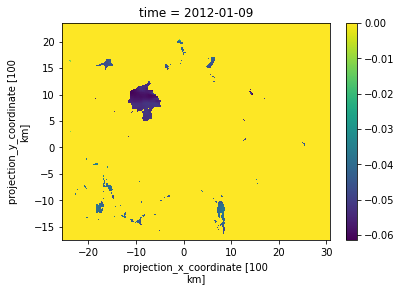

In [220]:
bpred_xr.isel(time=100).plot()

In [184]:
ds.maskok

<xarray.DataArray (y: 329, x: 450)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Dimensions without coordinates: y, x

In [186]:
# put back the nan
ne = bpred_xr.where(ds.maskok)

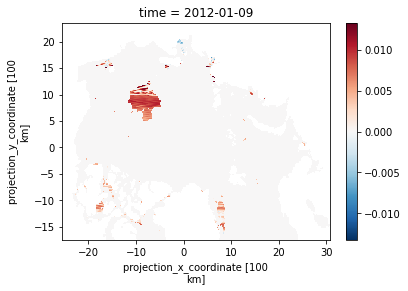

In [189]:
ne.isel(time=100).plot()

In [142]:
m3.ytrue.shape

(3013, 3165, 1)

In [154]:
m3.ml_dir

'Leo/results/lstm_230302-143058/ml/'

In [153]:
m3.rootdir

'/scratch/project_465000269/edelleo1/'

In [147]:
ytrue_xr = xr.DataArray(ds.outputs[0], 
                coords={'time': m3.chrono.to_numpy()[:,0], 'y': ds.outputs[0].y, 'x':ds.outputs[0].x},
                dims=["time", "y", "x"])

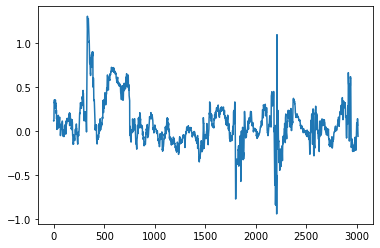

In [85]:
plt.plot(m3.ytrue[:,1000]);

# ------------------------------------

In [ ]:
ds.maskok

In [ ]:
reload(model_lstm)

In [ ]:
ds.config.ml_name = 'LSTMconv'

In [ ]:
m3 = model_lstm.ModelLSTM(ds, ds.dataset['Xtrain'].shape[1], ds.dataset['Xtrain'].shape[2], 
                    rootdir=ds.config.rootdir, ml_dir=ds.config.ml_dir, 
                    fig_dir=ds.config.fig_dir)

In [ ]:
m3.compile_models()

# ------------------------------------

In [ ]:
if 'CNN' in ds.config.ml_name:
    m4 = model_cnn.ModelCNN(ds, ds.dataset['Xtrain'].shape[1], ds.dataset['Xtrain'].shape[2], 
                        rootdir=ds.config.rootdir, ml_dir=ds.config.ml_dir, 
                        fig_dir=ds.config.fig_dir)

elif 'LSTM' in ds.config.ml_name:
    m4 = model_lstm.ModelLSTM(ds, ds.dataset['Xtrain'].shape[1], ds.dataset['Xtrain'].shape[2], 
                        rootdir=ds.config.rootdir, ml_dir=ds.config.ml_dir, 
                        fig_dir=ds.config.fig_dir)

In [ ]:
ds.dataset['Xtrain'].shape

In [ ]:
# m4.compile_models(npca=n_components, name='LSTM_at')
m4.compile_models(npca=n_components, name='LSTM3_bk')

In [ ]:
m4.print_summary()

In [ ]:
m4.fit_multiple(ds.dataset, suffix=suffixe) 

In [ ]:
# m4.print_histories()
m4.predict_multiple(ds.dataset, ds.point)
# m4.save_prediction()
#m4.save_model()

## Plot

In [ ]:
ofile = f'{m4.type}_ypred.png'
mdl_ypred_PCA.draw_local(m4, odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=True, ofile=ofile)

In [ ]:
ofile = f'{m4.type}_ypred.png'
mdl_ypred_PCA.draw_local(m4, odir=m4.rootdir+m4.fig_dir, savefig=False, showfig=True, ofile=ofile)

# Apply to another point

In [ ]:
# to change point used:
new_point = kmean_cluster.sel_rdn_pt(km, cluster_sel, return_neighbors=True)

In [ ]:
# visualize random point
kmean_cluster.plot_1cluster(cluster_sel, km, points=[idx_pt[0], new_point[0]], odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=True)

In [ ]:
ds.redefine_point(new_point)

In [ ]:
m4.predict_multiple(ds.dataset, ds.point)
# m4.save_prediction()

In [ ]:
ofile = f'{m4.type}_ypred.png'
mdl_ypred_PCA.draw_local(m4, odir=m4.rootdir+m4.fig_dir, savefig=True, showfig=True, ofile=ofile)

# Train with an average of the 8 surroundings points

# Train with an average of all the cluster

# Train LSTM + other architectures

- Use an average of multiple points
- include multiple points in training dataset